## TO DO:

**EDA**

- add findings 

**SEELCTION**

- feasture selection techniques - extra tree 
- compare diffent model by creating a function 
- go trhough tutorials as guide specilally to teh deep leraning part
- Bayesian optimization https://medium.com/@hiepnguyen034/improving-neural-networks-performance-with-bayesian-optimization-efbaa801ad26 

# Description
In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

# Resources
- https://github.com/krishnaik06/NYC-Taxi-Fares-Prediction 
- https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters
- https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [1]:
# Dependecies

import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt, rcParams

# Set a standard size and style
sns.set_style('whitegrid') 
rcParams['figure.figsize'] = (6, 4) # define plot sizes 

In [2]:
# We will take a sample of our dataset

url = 'https://raw.githubusercontent.com/krishnaik06/NYC-Taxi-Fares-Prediction/master/taxifare.csv'

data = pd.read_csv(url)

In [3]:
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


## 1. Feature engineering

In [4]:
# My utc is 5  hours ahead NY and therefore I substract 5 hours 
df = data.copy()

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(hours=5)

In [5]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 03:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 10:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 06:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 16:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-16 21:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [6]:
# Generat new date features
df['Month']=df['pickup_datetime'].dt.month
df['Day']=df['pickup_datetime'].dt.day
df['Hours']=df['pickup_datetime'].dt.hour
df['Minutes']=df['pickup_datetime'].dt.minute
df['Day of week']=df['pickup_datetime'].dt.dayofweek

In [7]:
# Create a column to specify morning and night 
df['morning_night']=np.where(df['Hours']<12,0,1)

# Drop pickup datetime
df.drop('pickup_datetime',axis=1,inplace=True)

In [8]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,4,19,3,17,0,0
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,4,17,10,43,5,0
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,4,17,6,23,5,0
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,4,11,16,25,6,1
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4,16,21,19,4,1


Calculating Haversine distances 


In [9]:
# Calculating Haversine distances 

from sklearn.metrics.pairwise import haversine_distances
from math import radians
newdelhi = [28.6139, 77.2090]
bangalore = [12.9716, 77.5946]

newdelhi_in_radians = [radians(_) for _ in newdelhi]
bangalore_in_radians = [radians(_) for _ in bangalore]

result = haversine_distances([newdelhi_in_radians, bangalore_in_radians])
result*6371

array([[   0.       , 1739.8021019],
       [1739.8021019,    0.       ]])

In [10]:
np.radians(df['dropoff_latitude']-df["pickup_latitude"])

0         0.000248
1         0.000062
2         0.000264
3        -0.000144
4         0.000156
            ...   
119995   -0.000834
119996   -0.000564
119997   -0.000733
119998    0.000109
119999   -0.000155
Length: 120000, dtype: float64

In [11]:
# Create a function to calcualte haversine distance 
def haversine(df):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1= np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    #### Based on the formula  x1=drop_lat,x2=dropoff_long 
    dlat = np.radians(df['dropoff_latitude']-df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]-df["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [12]:
df['total_distance']=haversine(df)

In [13]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,4,19,3,17,0,0,2.126312
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,4,17,10,43,5,0,1.392307
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,4,17,6,23,5,0,3.326763
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,4,11,16,25,6,1,1.864129
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4,16,21,19,4,1,7.231321


He used PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since he transformed 2D-> 2D. The rotation could help for decision tree splits, and it did actually.

In [14]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values
                   ))

In [15]:
coords 

array([[ 40.730521, -73.992365],
       [ 40.740558, -73.990078],
       [ 40.751118, -73.994149],
       ...,
       [ 40.707799, -74.011541],
       [ 40.730765, -73.992697],
       [ 40.763015, -73.967623]])

In [16]:
from sklearn.decomposition import PCA
 
pca = PCA().fit(coords)
df['pickup_pca0'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 0]
df['pickup_pca1'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 1]
df['dropoff_pca0'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
df['dropoff_pca1'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [17]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,4,19,3,17,0,0,2.126312,-0.023425,0.013288,-0.002478,0.006357
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,4,17,10,43,5,0,1.392307,-0.017568,0.004822,-0.001537,0.007415
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,4,17,6,23,5,0,3.326763,-0.017419,-0.006495,0.019843,-0.007848
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,4,11,16,25,6,1,1.864129,-0.012045,-0.010055,0.002790,0.004756
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4,16,21,19,4,1,7.231321,-0.020766,0.010388,0.061469,0.033739


In [18]:
df.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],axis=1,inplace=True)

In [19]:
df.head()

,fare_amount,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,6.5,0,1,4,19,3,17,0,0,2.126312,-0.023425,0.013288,-0.002478,0.006357
1,6.9,0,1,4,17,10,43,5,0,1.392307,-0.017568,0.004822,-0.001537,0.007415
2,10.1,1,2,4,17,6,23,5,0,3.326763,-0.017419,-0.006495,0.019843,-0.007848
3,8.9,0,1,4,11,16,25,6,1,1.864129,-0.012045,-0.010055,0.002790,0.004756
4,19.7,1,1,4,16,21,19,4,1,7.231321,-0.020766,0.010388,0.061469,0.033739


## 2. EDA

In [20]:
# There are no missing values

df.isnull().sum()

fare_amount        0
fare_class         0
passenger_count    0
Month              0
Day                0
Hours              0
Minutes            0
Day of week        0
morning_night      0
total_distance     0
pickup_pca0        0
pickup_pca1        0
dropoff_pca0       0
dropoff_pca1       0
dtype: int64

<AxesSubplot:>

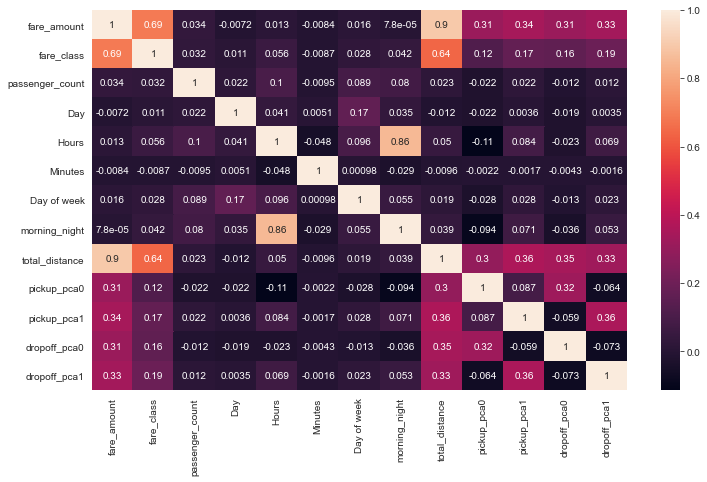

In [21]:
plt.figure(figsize=(12,7))
sns.heatmap(df.drop('Month',axis= 1).corr(), annot=True)

<AxesSubplot:>

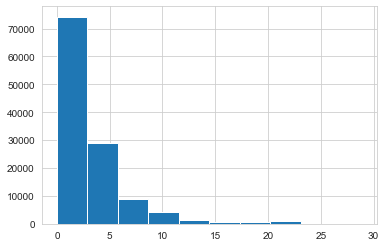

In [22]:
# Checking teh distribution 
df.total_distance.hist()

<AxesSubplot:xlabel='total_distance'>

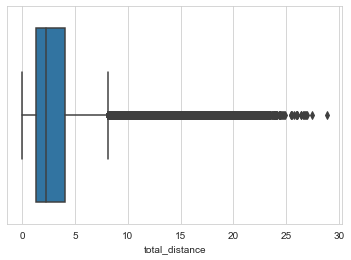

In [23]:
sns.boxplot(df.total_distance ) 

<AxesSubplot:>

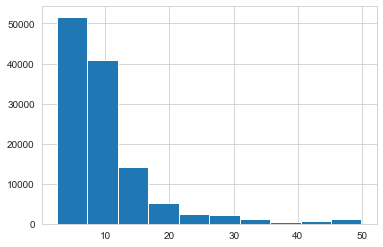

In [24]:
df.fare_amount.hist()

In [25]:
# Checking the outliers for non gaussian distributions
def identify_outliers(data = df, column = 'total_distance'):
    from numpy import percentile
    # To indentify outliers in a Non Gaussian distribution we use 25 and 75 percentiles 
    q25, q75 = percentile(data[column], 25) , percentile(df.total_distance, 75) 
    iqr = q75 - q25
    # calculate the outlier cutoff - Lower and upper
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    #print(f'Upper {upper}, Lower {lower}')
    # identify outliers
    outliers = [x for x in data[column] if x < lower or x > upper]
    output = ('Identified outliers: %d' % len(outliers))
    return output

In [26]:
cols = ['fare_amount' , 'total_distance' ]

In [27]:
for col in cols:
    print(col,identify_outliers(column = col)) 


fare_amount Identified outliers: 120000
total_distance Identified outliers: 8995


In [28]:
df.head()

,fare_amount,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,6.5,0,1,4,19,3,17,0,0,2.126312,-0.023425,0.013288,-0.002478,0.006357
1,6.9,0,1,4,17,10,43,5,0,1.392307,-0.017568,0.004822,-0.001537,0.007415
2,10.1,1,2,4,17,6,23,5,0,3.326763,-0.017419,-0.006495,0.019843,-0.007848
3,8.9,0,1,4,11,16,25,6,1,1.864129,-0.012045,-0.010055,0.002790,0.004756
4,19.7,1,1,4,16,21,19,4,1,7.231321,-0.020766,0.010388,0.061469,0.033739


In [29]:
df['passenger_count'].describe()

count    120000.000000
mean          1.347167
std           0.759263
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: passenger_count, dtype: float64

In [30]:
# There are no outliers in the column passenger count

print(identify_outliers(data = data , column = 'pickup_latitude')) 

Identified outliers: 120000


<AxesSubplot:>

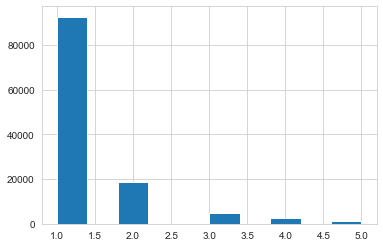

In [31]:
df['passenger_count'].hist()

**Does the number of passengers affect the fare?**

<AxesSubplot:xlabel='passenger_count', ylabel='fare_amount'>

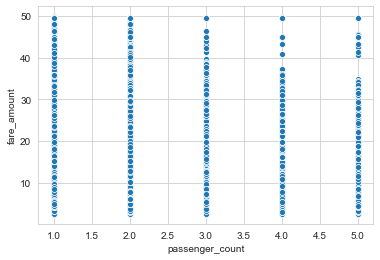

In [32]:
sns.scatterplot(x = 'passenger_count' , y = 'fare_amount' , data= df )

<AxesSubplot:xlabel='passenger_count'>

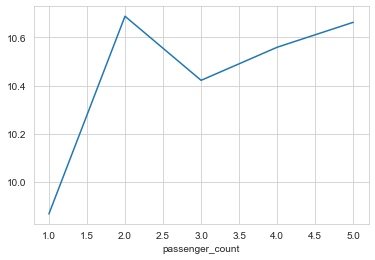

In [33]:
# 2 passengers 
df.groupby('passenger_count')['fare_amount'].mean().plot(kind='line')

<AxesSubplot:xlabel='passenger_count'>

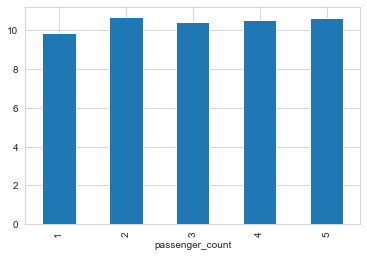

In [34]:
df.groupby('passenger_count')['fare_amount'].mean().plot(kind='bar')

- **Does the date and time of pickup affect the fare?**
- **Does the day of the week affect the fare?**
- **Does the distance travelled affect the fare?**

In [35]:
def target_col(data = df , group = 'passenger_count', target = 'fare_amount' , kind = 'bar' ):
    var = data.groupby(group)[target].mean().sort_values(ascending = False)
    return var.plot(kind = kind)

passenger_count AxesSubplot(0.125,0.125;0.775x0.755)


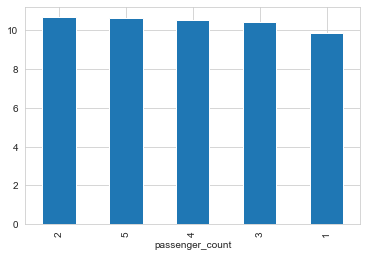

Hours AxesSubplot(0.125,0.125;0.775x0.755)


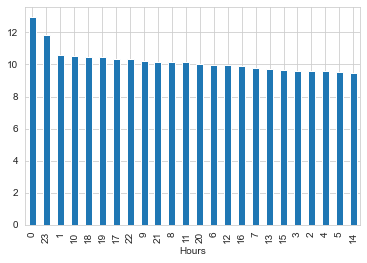

Day AxesSubplot(0.125,0.125;0.775x0.755)


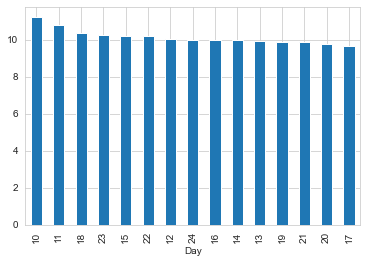

morning_night AxesSubplot(0.125,0.125;0.775x0.755)


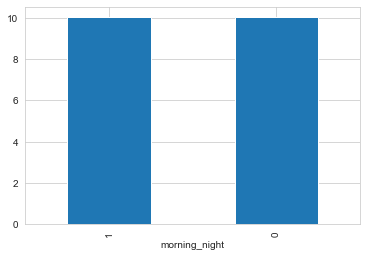

In [36]:
cols = ['passenger_count','Hours','Day' , 'morning_night' ]
for group in cols:
    print(group,target_col(group = group , kind='bar' ))
    plt.show()

In [37]:
df.head()

,fare_amount,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,6.5,0,1,4,19,3,17,0,0,2.126312,-0.023425,0.013288,-0.002478,0.006357
1,6.9,0,1,4,17,10,43,5,0,1.392307,-0.017568,0.004822,-0.001537,0.007415
2,10.1,1,2,4,17,6,23,5,0,3.326763,-0.017419,-0.006495,0.019843,-0.007848
3,8.9,0,1,4,11,16,25,6,1,1.864129,-0.012045,-0.010055,0.002790,0.004756
4,19.7,1,1,4,16,21,19,4,1,7.231321,-0.020766,0.010388,0.061469,0.033739


In [38]:
# Observe that there is only one month
df.Month.nunique()

1

**Does the distance travelled affect the fare?**

<AxesSubplot:>

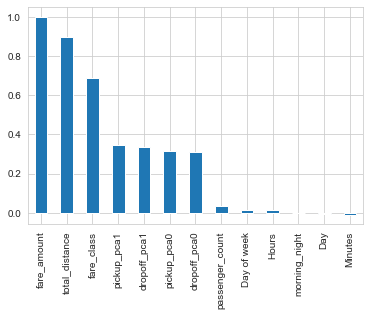

In [39]:
df.drop('Month',axis= 1).corr()['fare_amount'].sort_values(ascending=False).plot(kind='bar')

### Findings 
- 

## 3. Feature Selection
xgboost , Extra tree regressor

In [40]:
############
# XGBOOST method 1
############
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import SelectFromModel

X = df.drop('fare_amount',axis=1 )
y = df.fare_amount

In [41]:
X.head()

,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,0,1,4,19,3,17,0,0,2.126312,-0.023425,0.013288,-0.002478,0.006357
1,0,1,4,17,10,43,5,0,1.392307,-0.017568,0.004822,-0.001537,0.007415
2,1,2,4,17,6,23,5,0,3.326763,-0.017419,-0.006495,0.019843,-0.007848
3,0,1,4,11,16,25,6,1,1.864129,-0.012045,-0.010055,0.002790,0.004756
4,1,1,4,16,21,19,4,1,7.231321,-0.020766,0.010388,0.061469,0.033739


In [42]:
# Train test split 

X_train, X_valid , y_train , y_valid = train_test_split(X,y , test_size =0.3,random_state = 0)

In [43]:
print(X_train.shape)
print(X_valid.shape)

(84000, 13)
(36000, 13)


In [44]:
model = XGBRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_valid)
error = mse(y_valid,pred)

[19:54:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
error

6.051572295744748

In the example below we first train and then evaluate an XGBoost model on the entire training dataset and test datasets respectively.

In [46]:
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_X_train, y_train)
	
    # eval model
	select_X_test = selection.transform(X_valid)
	predictions = selection_model.predict(select_X_test)
	error = mse(y_valid, predictions)
	print("Thresh=%.3f, n=%d, MSE: %.2f" % (thresh, select_X_train.shape[1], error))

[19:54:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=13, MSE: 6.05
[19:55:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=13, MSE: 6.05
[19:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.001, n=11, MSE: 6.05
[19:55:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=10, MSE: 6.05
[19:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.003, n=9, MSE: 6.06
[19:56:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.005, n=8, MSE: 6.08
[19:56:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.0

In [47]:
# Here we can see the best score is achieved with 5 features

[19:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


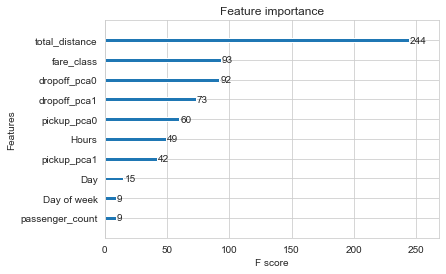

In [48]:
############
# XGBOOST method 2
############

# plot feature importance
from xgboost import plot_importance

# fit model no training data
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

In [49]:
############
# Extra Tree Regressor 
############
from sklearn.ensemble import ExtraTreesRegressor
model_tree = ExtraTreesRegressor()
model_tree.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

<AxesSubplot:>

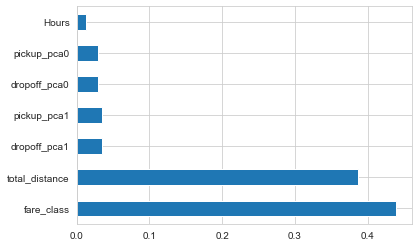

In [50]:
f_importances = pd.Series(model_tree.feature_importances_,index = X.columns )
f_importances.nlargest(7).plot(kind='barh')

### Findings 
- The distance and fare class are the most important features based on Extra tree regressor and Xgboost feature importances

## 4. Modelling
xgboost, random forest ,  

Evaluate various models 

In [51]:
X.head()

,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,0,1,4,19,3,17,0,0,2.126312,-0.023425,0.013288,-0.002478,0.006357
1,0,1,4,17,10,43,5,0,1.392307,-0.017568,0.004822,-0.001537,0.007415
2,1,2,4,17,6,23,5,0,3.326763,-0.017419,-0.006495,0.019843,-0.007848
3,0,1,4,11,16,25,6,1,1.864129,-0.012045,-0.010055,0.002790,0.004756
4,1,1,4,16,21,19,4,1,7.231321,-0.020766,0.010388,0.061469,0.033739


In [ ]:
# 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score

seed = 0  
models = []

models.append(('XGB', XGBRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('SVM', SVR()))

results = [] 
names = []
for name,model in models: 
    print(name,model)
    #kfold = KFold(n_splits = 5, random_state = 0 , shuffle=True ) # change the seed
    #cv_results = -1 * cross_val_score(model,X,y, cv = kfold,scoring='neg_mean_squared_error')
    #results.append(cv_results)
    #names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(f'Now training {name}')
    #print(msg)

## 5. Hyper parameter tunning 
randomized, gaussian  

## 6. Artificial Neural networks


# BREAK 

In [171]:
! pwd

/Users/Tabe/Desktop/Courses/Data-Science /Test-Projects/Machine-Learning-Projects/New York City Taxi Fare Prediction


In [172]:
import datetime

# 2 Pull request
! git pull

# 3
now = datetime.datetime.now()
commit_message = "Last run on " + str(now)
! cd '/Users/Tabe/Desktop/Courses/Data-Science /Test-Projects/Machine-Learning-Projects/New York City Taxi Fare Prediction'


remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/tabers77/Machine-Learning-Projects
   6816251..03ecfae  main       -> origin/main
Updating 6816251..03ecfae
Fast-forward
 README.md | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [173]:
! echo $commit_message > commit_message.txt
! git add . 
! git commit -F commit_message.txt
! git push
#! git push origin master # here I choose either master or branch 
print ('Done!')

[main 0c550a5] Last run on 2020-11-15 11:15:29.037594
 3 files changed, 3153 insertions(+), 47 deletions(-)
Enumerating objects: 13, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 4 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (7/7), 126.77 KiB | 8.45 MiB/s, done.
Total 7 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 1 local object.
To https://github.com/tabers77/Machine-Learning-Projects.git
   03ecfae..0c550a5  main -> main
Done!
